# Weekend Movie Trip 
    For this project, i'm using clustering models to determine similar movies, based on tags and ratings. In reality, the key words in tags, could contain key words that describe the genres of the movie and the attitude people hold towards the movie. Based on this idea, movies with similar genres should be "grouped". 

In [1]:
# Load libraies
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Load Data Frames

In [2]:
#load Raw Data
data_Ratings = pd.read_csv("../data/raw/ratings.csv",encoding ='latin' ,low_memory =False)
data_Movies = pd.read_csv("../data/raw/movies.csv",encoding ='latin' ,low_memory =False)
data_Links = pd.read_csv("../data/raw//links.csv",encoding ='latin' ,low_memory =False)
data_Tags = pd.read_csv("../data/raw/tags.csv",encoding ='latin' ,low_memory =False)

In [3]:
data_Movies.head(5)
data_movies = data_Movies

In [4]:
data_Ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
data_Links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
data_Tags=data_Tags.dropna()
data_Tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
data_Movies.shape[0]

9742

# Process Data Frames

In [8]:
data_Movies['year'] = data_Movies.title.str.extract(pat='\((\d+)\)')
for i in range(0, data_Movies.shape[0]):
    length = len(data_Movies['title'][i])
    data_Movies['title'][i] = data_Movies['title'][i][0:(length-7)]

In [9]:
data_Movies.head(5)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [10]:
#Deal with genres
genres_list = []
onehot = data_Movies.genres.str.get_dummies()
data_Movies = data_Movies.join(onehot)
for row in data_Movies.iterrows():
    genre = row[1]["genres"].split("|")
    genres_list.append(genre)

In [11]:
data_Movies = data_Movies.drop('genres',axis = 1)
data_Movies.head(5)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


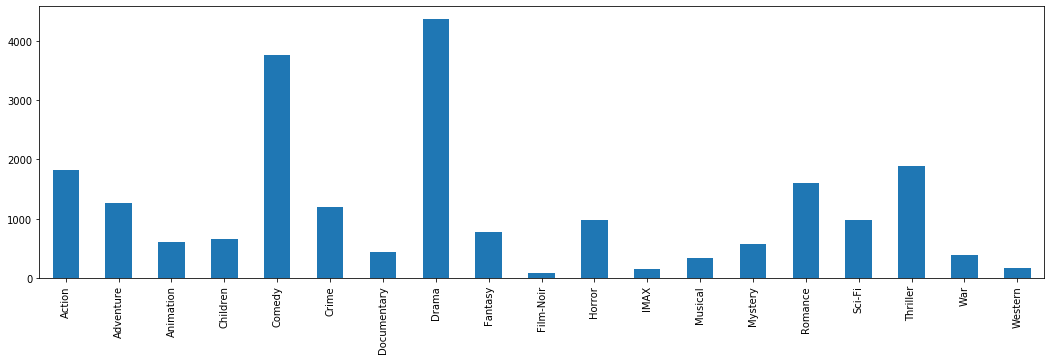

In [12]:
genre_sum = data_Movies.sum(axis=0)[3:23]
plt.figure(figsize = (18,5))
genre_sum.plot.bar()
plt.show()


    The top two overwelming movie genres are, Drama and Comedy

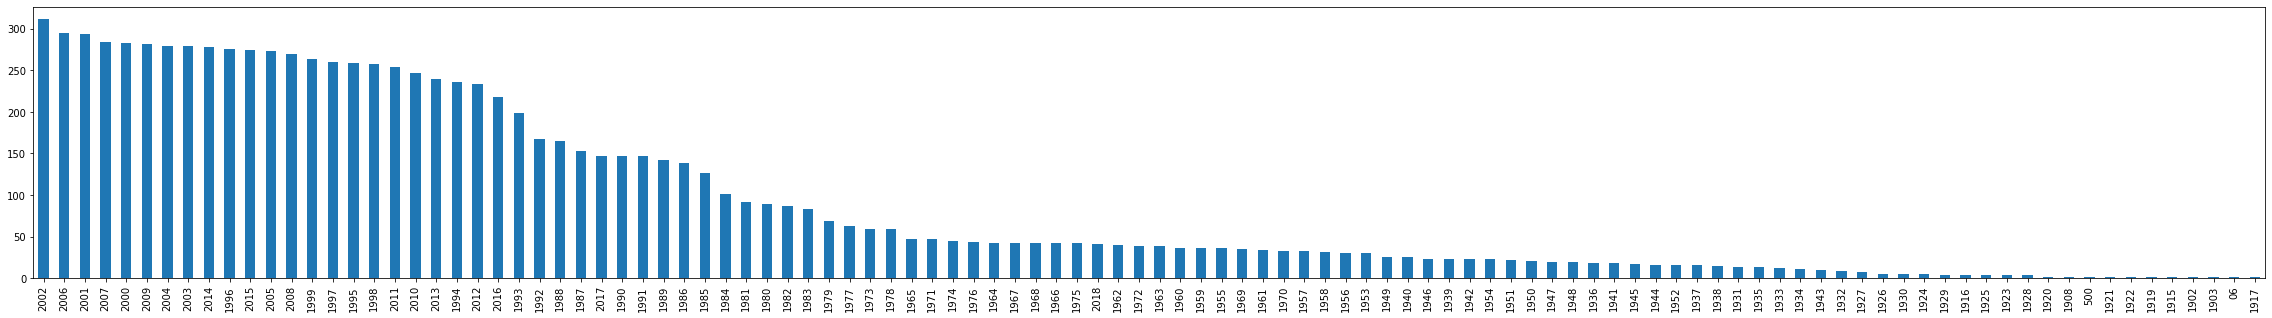

In [13]:
year_count = data_Movies['year'].value_counts()
plt.figure(figsize = (40,5))
year_count.plot.bar()
plt.show()

Here i found two year values that are wrong, 500 and 06.

In [14]:
def getAverageRating(movie_id):
    return data_Ratings.loc[data_Ratings['movieId'] == movie_id]['rating'].mean()
def getRatingCount(movie_id):
    return data_Ratings.loc[data_Ratings['movieId'] == movie_id]['rating'].count()
average_ratings = data_Movies['movieId'].map(lambda x: getAverageRating(x))
rating_count = data_Movies['movieId'].map(lambda x: getRatingCount(x))
data_Movies['Rating'] = average_ratings
data_Movies['Num_of_Ratings'] = rating_count

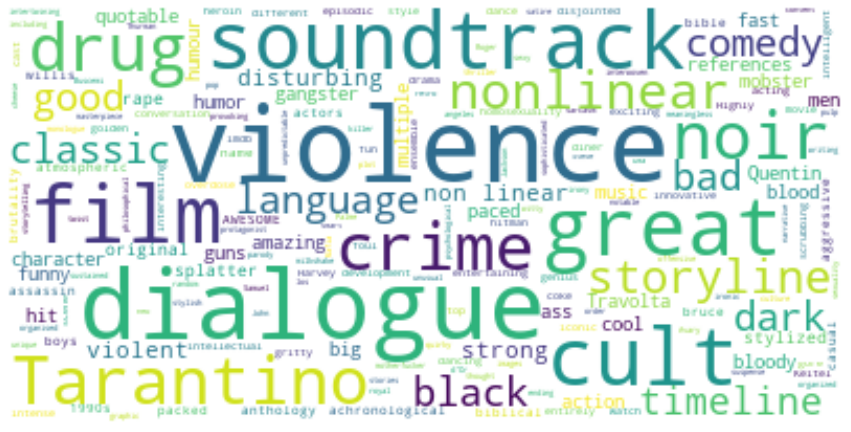

In [15]:
plt.figure(figsize = (15,15))
text = ' '
for i in range(0,data_Tags.shape[0]):
    if(data_Tags['movieId'][i] == 296):
        text = text +' '+ data_Tags['tag'][i] 
wordcloud = WordCloud(max_font_size=50, max_words=300, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()    

In [16]:
data = data_Movies.drop(columns=['movieId','year','Rating','Num_of_Ratings','title'])
data.head(5)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


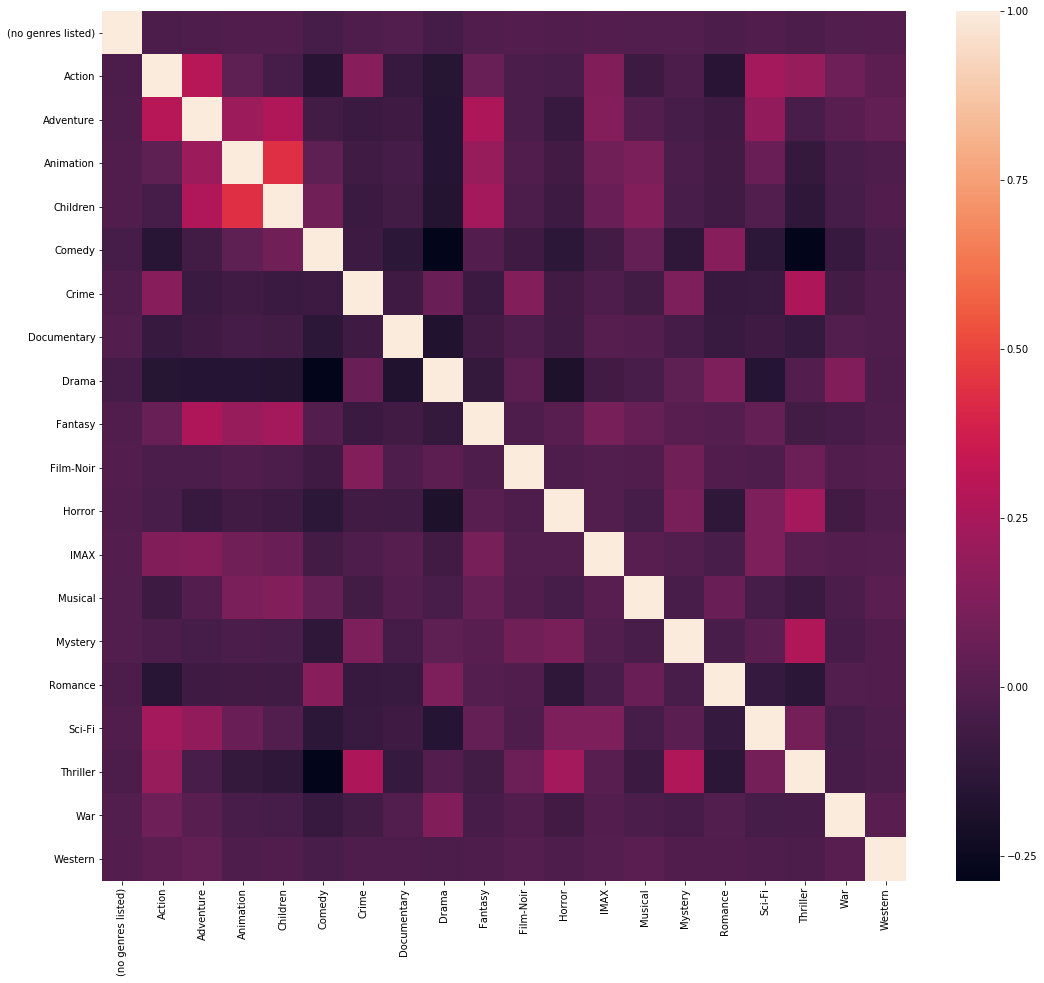

In [17]:
plt.figure(figsize = (18,16))
sns.heatmap(data.corr())

      Since there are movies with multiple labels in the dataset, the number of them, i would like to know the porportion of them

In [18]:
Column_name_list = []
for col in data.columns: 
    Column_name_list.append(col)
Column_name_list

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [19]:
data['sum'] = data['Western']
for row in range(0,data.shape[0]):
    data['sum'][row] = 0
    for col in data.columns: 
        data['sum'][row] = data['sum'][row] + data[col][row]
data['sum'] = data['sum']/2

In [20]:
for i in range(0,int(data['sum'].max()+1)):
    print("Movies contains: %d labels %d labels" %(i,data.loc[data['sum'] == i].shape[0]))

Movies contains: 0 labels 0 labels
Movies contains: 1 labels 2851 labels
Movies contains: 2 labels 3218 labels
Movies contains: 3 labels 2338 labels
Movies contains: 4 labels 987 labels
Movies contains: 5 labels 271 labels
Movies contains: 6 labels 63 labels
Movies contains: 7 labels 12 labels
Movies contains: 8 labels 1 labels
Movies contains: 9 labels 0 labels
Movies contains: 10 labels 1 labels


# Merge dataframes

In [21]:
data_Ratings = data_Ratings.drop(columns=["timestamp"])
data_Ratings.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [22]:
data_Tags = data_Tags.drop(columns=["timestamp"])
data_Tags.head(5)

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [23]:
df = pd.merge(data_Tags,data_Ratings)
#df = pd.merge(df, data_Movies)
df = pd.merge(df, data_Movies)
df.dropna()
df.head(5)

,userId,movieId,tag,rating,title,year,(no genres listed),Action,Adventure,Animation,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings
0,2,60756,funny,5.0,Step Brothers,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,3.553571,28
1,2,60756,Highly quotable,5.0,Step Brothers,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,3.553571,28
2,2,60756,will ferrell,5.0,Step Brothers,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,3.553571,28
3,62,60756,comedy,3.5,Step Brothers,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,3.553571,28
4,62,60756,funny,3.5,Step Brothers,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,3.553571,28


# Data Preparation
    Use rating and tags as freatures to cluster genres

In [24]:
#Result = df[['title','rating','genres','tag']]
Result = df[['title','rating','tag']]
Result['genres']= data_movies['genres']
object = LabelEncoder()
df['tag'] = object.fit_transform(df['tag'].astype('str'))
df['title'] = object.fit_transform(df['title'].astype('str'))
#df['genres'] =  object.fit_transform(df['genres'].astype('str'))

In [25]:
data_Movies = data_Movies.drop(columns = ['year','title','movieId','Rating','Num_of_Ratings'])

# Clustering using MeanShift

In [35]:
feature = ["tag","rating"]
Input = df[feature]
label = data_Movies
#label = data
X_std = StandardScaler().fit_transform(Input)
meanshift_5 = MeanShift(bandwidth=.6)
meanshift_5.fit(X_std)
print(meanshift_5.predict(X_std))
df['meanshift_5'] = meanshift_5.predict(X_std)

[1 6 3 ... 2 1 1]


# Clustering using KMeans 

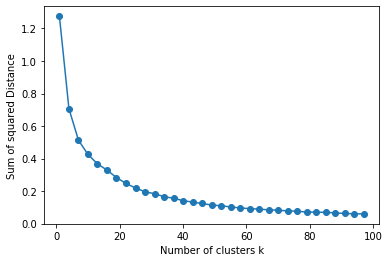

In [37]:
distances = []
K = range(1,100, 3)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_std)
    kmeanModel.fit(X_std)
    distances.append(sum(np.min(cdist(X_std, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
# Plot the elbow graph
plt.plot(K, distances, '-o')
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sum of squared Distance')
plt.show()

In [38]:
kmeans = KMeans(n_clusters=20).fit_predict(X_std)
df['kmeans_Cluster'] = kmeans

# Visualizition Result
## Meanshift Visualization

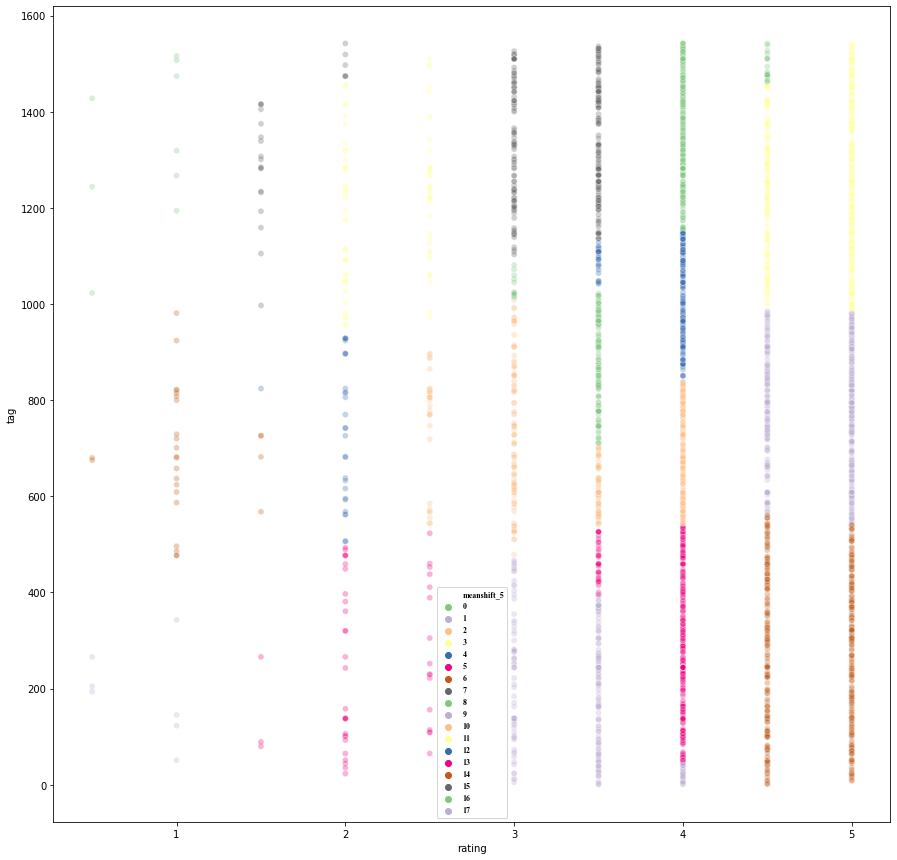

In [36]:
plt.figure(figsize=(15,15))
sns.scatterplot(x="rating", y="tag", hue="meanshift_5", palette=sns.color_palette("Accent",n_colors=len(df.meanshift_5.unique())), data=df, legend="brief", alpha=0.3)
plt.legend(prop={'family' : 'Times New Roman', 'size': 8})
plt.show()

# KMeans Visualization

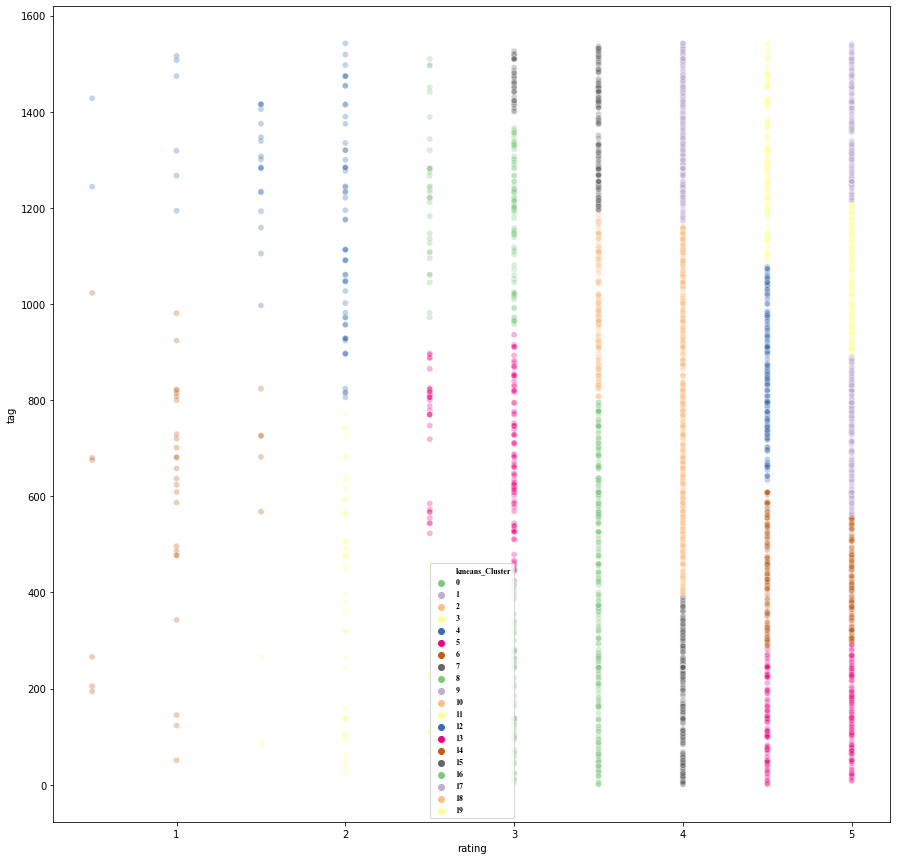

In [39]:
plt.figure(figsize=(15,15))
sns.scatterplot(x="rating", y="tag", hue="kmeans_Cluster", palette=sns.color_palette("Accent",n_colors=len(df.kmeans_Cluster.unique())), data=df, legend="brief", alpha=0.3)
plt.legend(prop={'family' : 'Times New Roman', 'size': 8})
plt.show()

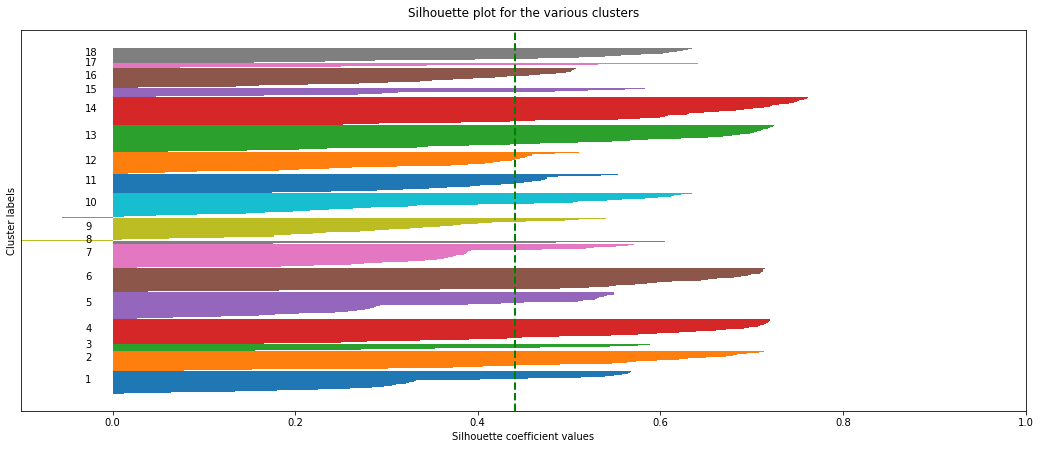

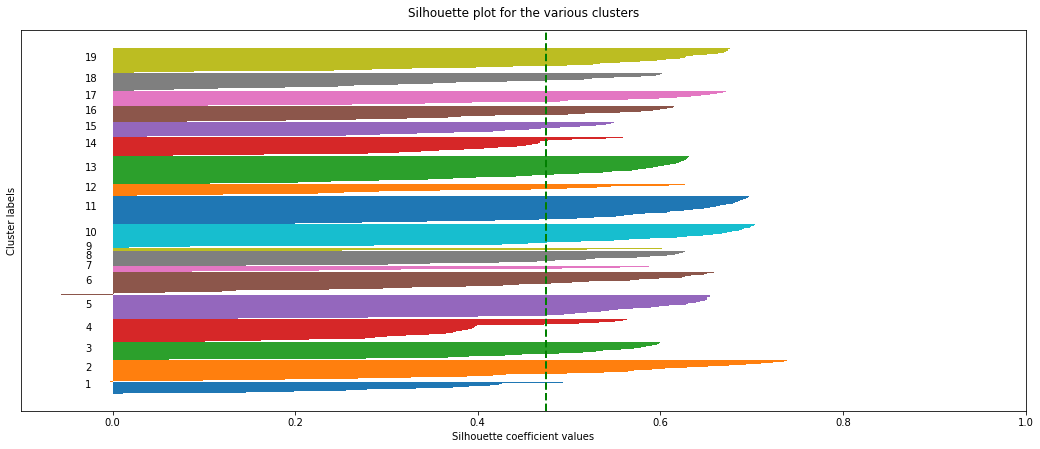

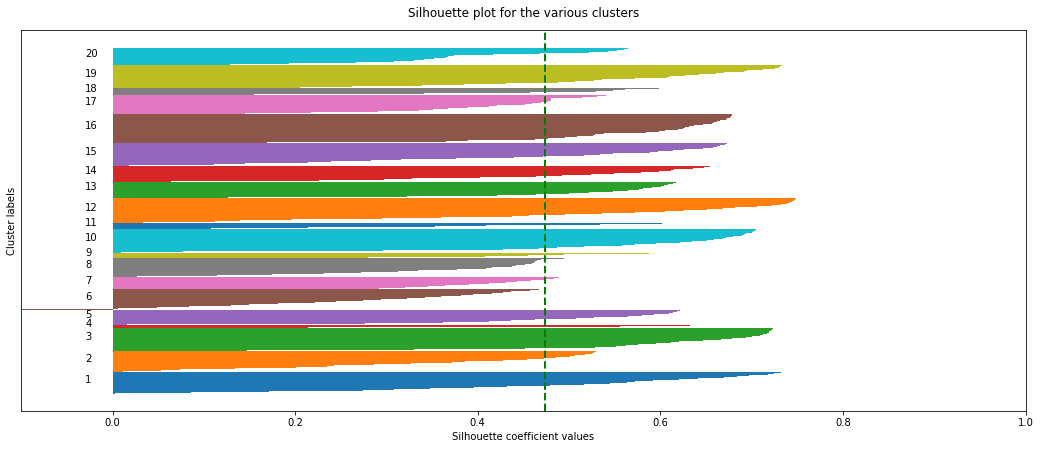

In [40]:
for i, k in enumerate([18,19,20]):
    fig,ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

    Based on the plots above, using kmeans(20 clusters), recieve an accuracy of around 50% 

# Most inportant, Let's see what's in each cluster

In [41]:
df

,userId,movieId,tag,rating,title,year,(no genres listed),Action,Adventure,Animation,...,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings,meanshift_6,meanshift_5,kmeans_Cluster
0,2,60756,911,5.0,1223,2008,0,0,0,0,...,0,0,0,0,0,3.553571,28,1,1,3
1,2,60756,227,5.0,1223,2008,0,0,0,0,...,0,0,0,0,0,3.553571,28,6,6,13
2,2,60756,1528,5.0,1223,2008,0,0,0,0,...,0,0,0,0,0,3.553571,28,3,3,9
3,62,60756,746,3.5,1223,2008,0,0,0,0,...,0,0,0,0,0,3.553571,28,8,8,16
4,62,60756,911,3.5,1223,2008,0,0,0,0,...,0,0,0,0,0,3.553571,28,8,8,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,606,1948,74,3.5,1316,1963,0,0,1,0,...,1,0,0,0,0,3.642857,7,9,9,0
3472,606,5694,11,3.0,1221,1983,0,0,0,0,...,0,0,0,0,0,2.250000,2,9,9,0
3473,606,6107,544,4.0,889,1982,0,0,0,0,...,0,0,0,1,0,4.000000,1,2,2,2
3474,610,3265,952,5.0,532,1992,0,1,0,0,...,0,0,1,0,0,4.000000,9,1,1,3


In [42]:
Result['meanshift_5'] = df['meanshift_5']
Result['kmeans_Cluster'] = df['kmeans_Cluster']


Result = Result.drop_duplicates(subset='title', keep='first')

In [47]:
Result.loc[Result['meanshift_5'] == 5].head(10)

,title,rating,tag,genres,meanshift_5,kmeans_Cluster
17,"Departed, The",4.0,Leonardo DiCaprio,Comedy,5,7
43,Just Eat It: A Food Waste Story,4.0,Sustainability,Mystery|Thriller,5,2
59,Jumanji,4.0,Robin Williams,Action|Sci-Fi|Thriller,5,2
99,Toy Story 2,4.0,Pixar,Action|Adventure|Comedy|Crime,5,2
107,Gladiator,3.5,Romans,Drama|Mystery|Romance,5,16
129,"League of Extraordinary Gentlemen, The (a.k.a....",3.5,Peta Wilson,Comedy|Drama,5,0
130,"League of Extraordinary Gentlemen, The (a.k.a....",3.5,Sean Connery,Comedy|War,5,16
146,Anchorman: The Legend of Ron Burgundy,4.0,Steve Carell,Comedy,5,2
147,Anchorman: The Legend of Ron Burgundy,4.0,Will Ferrell,Drama,5,2
159,Lemony Snicket's A Series of Unfortunate Events,4.0,Jim Carrey,Fantasy|Horror|Mystery,5,7


In [48]:
Result.loc[Result['kmeans_Cluster'] == 4].head(10)

,title,rating,tag,genres,meanshift_5,kmeans_Cluster
16,"Departed, The",1.0,way too long,Drama|Romance,16,4
252,Twilight,1.0,overrated,Drama|Thriller,16,4
770,Happy Gilmore,2.0,golf,Children|Drama,12,4
860,Top Gun,2.0,predictable,Drama|Mystery,11,4
1062,Terminator 2: Judgment Day,2.0,nuclear war,Action|Western,11,4
1063,Terminator 2: Judgment Day,2.0,sci-fi,Comedy|Musical|Romance,11,4
1065,Terminator 2: Judgment Day,2.0,time travel,Action|Drama,11,4
1157,"Matrix, The",2.0,martial arts,Comedy,11,4
1158,"Matrix, The",2.0,sci-fi,Action|Adventure|Comedy|Sci-Fi,11,4
1333,Now You See Me,1.5,illusions,Crime|Drama|Mystery|Thriller,15,4


# Conclusion:
    Based on the chart above, the result is appealing, based on, genres, tags and few movies that i watched, the movies with similar genres and tags are clustered pretty well, based on the result shown above. Most of the clusters created by these two modeled overlapped pretty well. The difference is caused by the different algorithms of the two models, which makes sense. Overall, using tag and rating as feature is valid for solving this clustering problem. 